In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import numba
from numba import jit
import cv2
import matplotlib.pyplot as plt
from skimage.util import random_noise
import time

In [3]:
@jit(nopython=True)
def grad_dis(u):
    m = u.shape[0]
    n = u.shape[1]
    D = np.zeros((m,n,2))
    for i in range(m):
        for j in range(n):
            if i != m-1:
                D[i,j,0] = u[i+1,j] - u[i,j]
            else:
                D[i,j,0] = 0
            if j != n-1:
                D[i,j,1] = u[i,j+1] - u[i,j]
            else:
                D[i,j,1] = 0
    return D

@jit(nopython=True)
def div_dis(u):
    m = u.shape[0]
    n = u.shape[1]
    l = u.shape[2]
    D = np.zeros((m,n,2))
    for i in range(m):
        for j in range(n):
            for k in range(l):
                if k == 0:
                    if i != m-1 and i != 0:
                        D[i,j,0] = u[i,j,0] - u[i-1,j,0]
                    elif i == 0:
                        D[i,j,0] = u[i,j,0]
                    else:
                        D[i,j,0] = -u[i-1,j,0]
                else:
                    if j != n-1 and j != 0:
                        D[i,j,1] = u[i,j,1] - u[i,j-1,1]
                    elif j == 0:
                        D[i,j,1] = u[i,j,1]
                    else:
                        D[i,j,1] = -u[i,j-1,1]
    return D[:,:,0]+D[:,:,1]

In [4]:
@jit(nopython=True)
def h_e(t,eps): 
    if abs(t) <= eps:
        h = t**2/(2*eps)
    else:
        h = abs(t)-eps/2
    return h

@jit(nopython=True)
def He(clambda,Du,eps):
    m = Du.shape[0]
    n = Du.shape[1]
    H = 0
    for i in range(m):
        for j in range(n):
            H += h_e(np.sqrt(Du[i,j,0]**2 + Du[i,j,1]**2),eps)
    return clambda*H

@jit(nopython=True)
def p(Du,eps,clambda):
    P = np.zeros(Du.shape)
    m = Du.shape[0]
    n = Du.shape[1]
    l = Du.shape[2]
    for i in range(m):
        for j in range(n):
            for k in range(l):
                P[i,j,k] = (clambda*Du[i,j,k])/max(eps,np.sqrt(Du[i,j,0]**2 + Du[i,j,1]**2))
    return P

@jit(nopython=True)
def df(p,x,u):
    Df = -div_dis(p) + x - u 
    return Df

In [5]:
def f(x,u,clambda,eps):
    F = He(clambda,grad_dis(x),eps) + 0.5*np.linalg.norm(x-u)**2
    return F

def escalar(A,B):
    m = A.shape[0]
    n = A.shape[1]
    s = 0
    for i in range(m):
        for j in range(n):
            s += A[i,j,0]*B[i,j,0] + A[i,j,1]*B[i,j,1]
    return s

def escalar2(A,B):
    m = A.shape[0]
    n = B.shape[1]
    s = 0
    for i in range(m):
        for j in range(n):
            a = A[i,j]
            b = B[i,j]
            s += a*b
    return s

def gap(x,p,u,clambda,eps):
    G = He(clambda,grad_dis(x),eps) + (eps/(2*clambda))*np.linalg.norm(p)**2 - escalar(p,grad_dis(x)) + 0.5*np.linalg.norm(u + div_dis(p) - x)**2
    return G

In [6]:
def mgrad(u,eps,clambda,x0,tol):
    it = []
    g = []
    maxiter = 750
    L = (1+2*clambda)/eps
    s = 2/(1+L)
    x = x0
    D = grad_dis(x)
    P = p(D,eps,clambda)
    Df = df(P,x,u)
    G = 1.0
    k = 0
    while G > tol and k < maxiter:
        x -= s*Df
        D = grad_dis(x)
        P = p(D,eps,clambda)
        Df = df(P,x,u)
        G = gap(x,P,u,clambda,eps)
        #print(G,k)
        it.append(k)
        g.append(G)
        k += 1
    return x, it, g

# Ejemplo 1

In [7]:
ej1 = cv2.imread('lady.jpeg')
ej1 = cv2.cvtColor(ej1,cv2.COLOR_RGB2GRAY)/255
ej1_noise = random_noise(ej1, mode='gaussian', mean=0.1)

In [8]:
x0 = np.random.rand(ej1_noise.shape[0],ej1_noise.shape[1])

In [9]:
t1 = time.time()
X1a,I1a,G1a = mgrad(ej1_noise,0.01,0.01,x0,1e-10)
t2 = time.time()
print(t2-t1)

275.573609828949


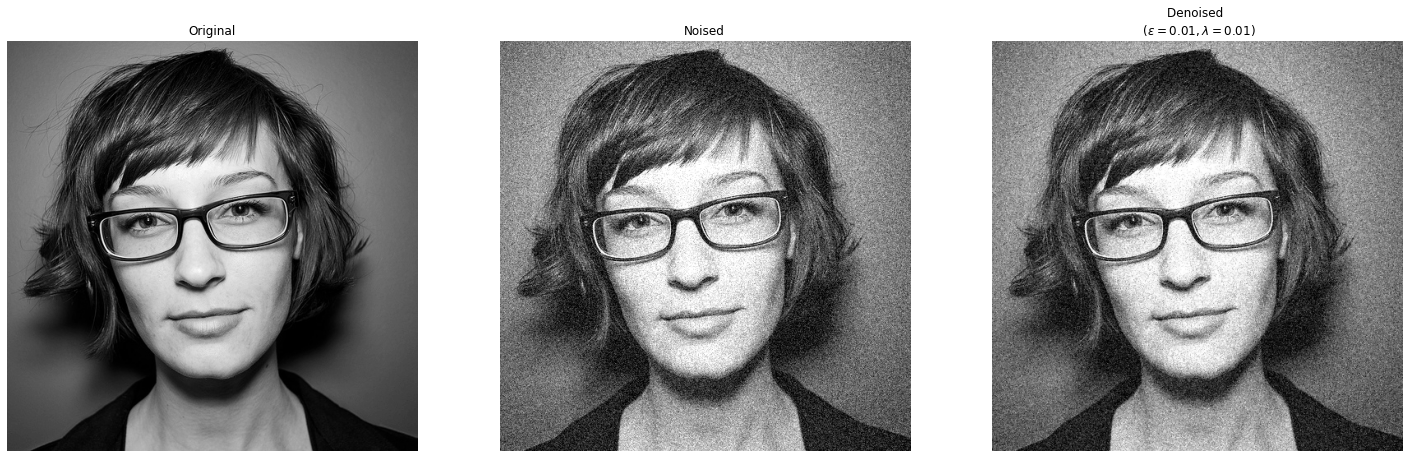

In [10]:
fig ,axs = plt.subplots(1,3,figsize=(25,25))
axs[0].imshow(ej1,cmap="gray")
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(ej1_noise,cmap="gray")
axs[1].set_title('Noised')
axs[1].axis('off')
axs[2].imshow(X1a,cmap="gray")
axs[2].set_title('Denoised \n ($\epsilon=0.01,\lambda=0.01$)')
axs[2].axis('off')
plt.savefig('Imagenes/ejemplo1-1.jpg',bbox_inches='tight')
plt.show()

In [11]:
t1 = time.time()
X1b,I1b,G1b = mgrad(ej1_noise,0.01,0.1,x0,1e-10)
t2 = time.time()
print(t2-t1)

258.96972036361694


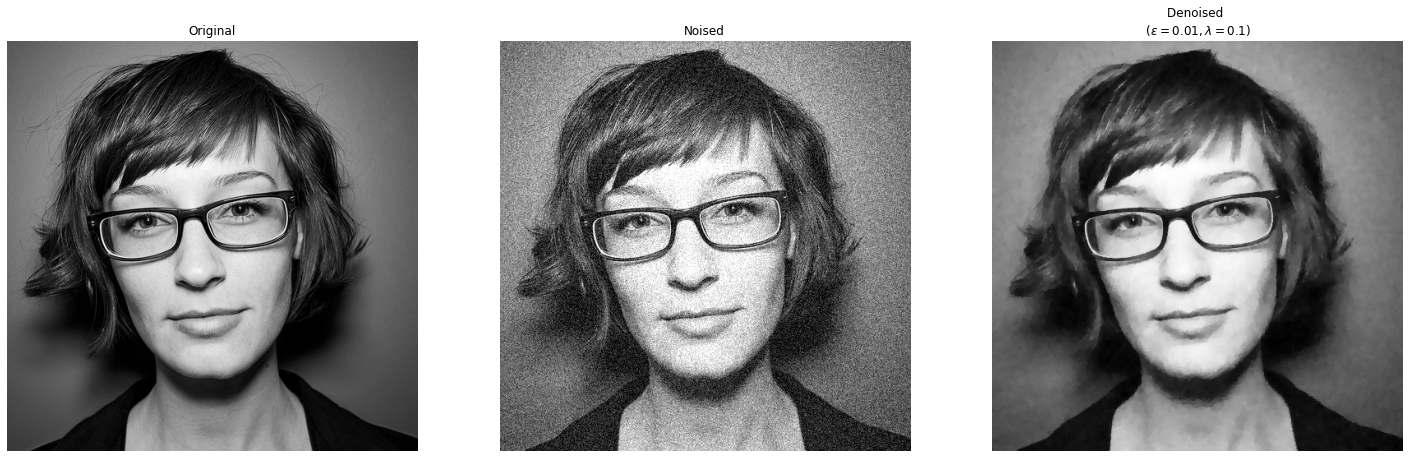

In [12]:
fig ,axs = plt.subplots(1,3,figsize=(25,25))
axs[0].imshow(ej1,cmap="gray")
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(ej1_noise,cmap="gray")
axs[1].set_title('Noised')
axs[1].axis('off')
axs[2].imshow(X1b,cmap="gray")
axs[2].set_title('Denoised \n ($\epsilon=0.01,\lambda=0.1$)')
axs[2].axis('off')
plt.savefig('Imagenes/ejemplo1-2.jpg',bbox_inches='tight')
plt.show()

In [13]:
t1 = time.time()
X1c,I1c,G1c = mgrad(ej1_noise,0.01,0.25,x0,1e-10)
t2 = time.time()
print(t2-t1)

264.8659710884094


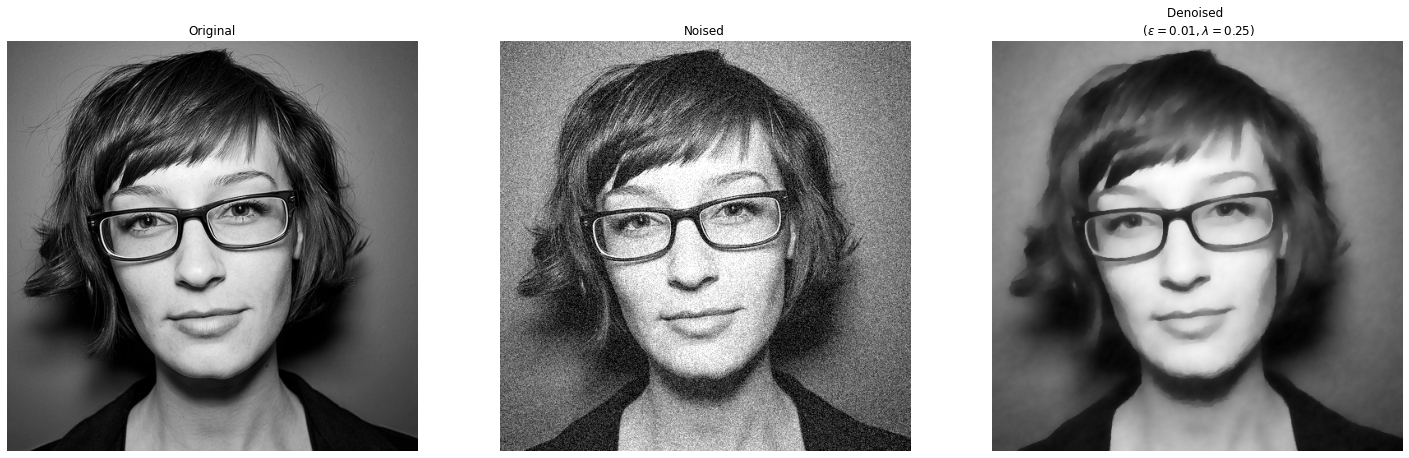

In [14]:
fig ,axs = plt.subplots(1,3,figsize=(25,25))
axs[0].imshow(ej1,cmap="gray")
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(ej1_noise,cmap="gray")
axs[1].set_title('Noised')
axs[1].axis('off')
axs[2].imshow(X1c,cmap="gray")
axs[2].set_title('Denoised \n ($\epsilon=0.01,\lambda=0.25$)')
axs[2].axis('off')
plt.savefig('Imagenes/ejemplo1-3.jpg',bbox_inches='tight')
plt.show()

# Ejemplo 2 (Cameraman)

In [15]:
ej2 = cv2.imread('cameraman.png')
ej2 = cv2.cvtColor(ej2,cv2.COLOR_RGB2GRAY)/255
ej2_noise = random_noise(ej2, mode='gaussian', mean=0.2)

In [16]:
xc0 = np.random.rand(ej2_noise.shape[0],ej2_noise.shape[1])

In [17]:
t1 = time.time()
X2a,I2a,G2a = mgrad(ej2_noise,0.01,0.1,xc0,1e-10)
t2 = time.time()
print(t2-t1)

274.3038454055786


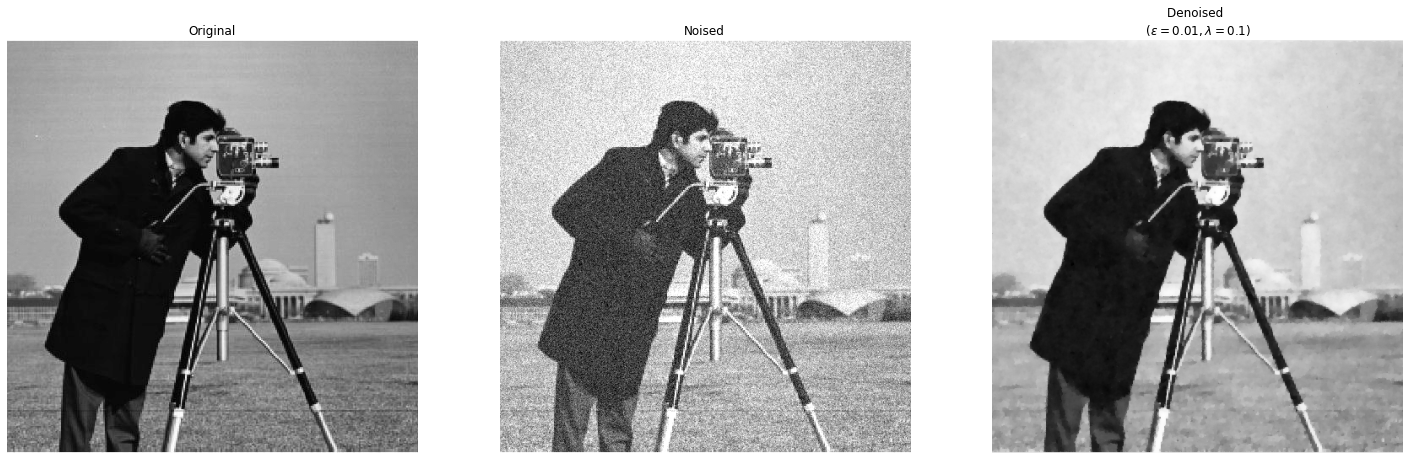

In [18]:
fig ,axs = plt.subplots(1,3,figsize=(25,25))
axs[0].imshow(ej2,cmap="gray")
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(ej2_noise,cmap="gray")
axs[1].set_title('Noised')
axs[1].axis('off')
axs[2].imshow(X2a,cmap="gray")
axs[2].set_title('Denoised \n ($\epsilon=0.01,\lambda=0.1$)')
axs[2].axis('off')
plt.savefig('Imagenes/ejemplo2-1.jpg',bbox_inches='tight')
plt.show()

In [19]:
t1 = time.time()
X2b,I2b,G2b = mgrad(ej2_noise,0.05,0.1,xc0,1e-10)
t2 = time.time()
print(t2-t1)

42.726863622665405


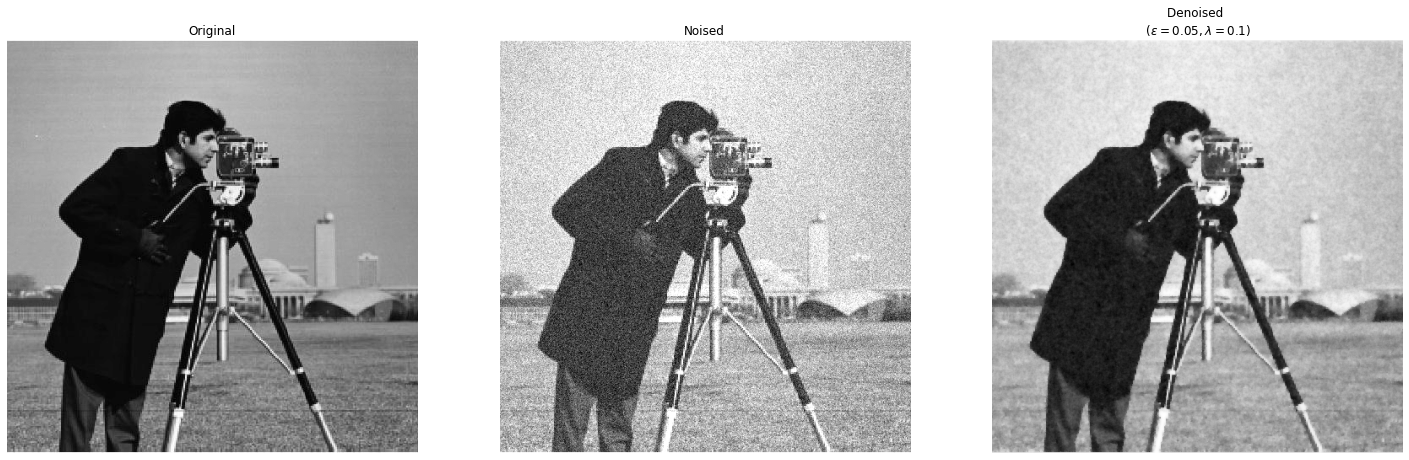

In [20]:
fig ,axs = plt.subplots(1,3,figsize=(25,25))
axs[0].imshow(ej2,cmap="gray")
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(ej2_noise,cmap="gray")
axs[1].set_title('Noised')
axs[1].axis('off')
axs[2].imshow(X2b,cmap="gray")
axs[2].set_title('Denoised \n ($\epsilon=0.05,\lambda=0.1$)')
axs[2].axis('off')
plt.savefig('Imagenes/ejemplo2-2.jpg',bbox_inches='tight')
plt.show()

In [21]:
t1 = time.time()
X2c,I2c,G2c = mgrad(ej2_noise,0.001,0.1,xc0,1e-10)
t2 = time.time()
print(t2-t1)

253.46680641174316


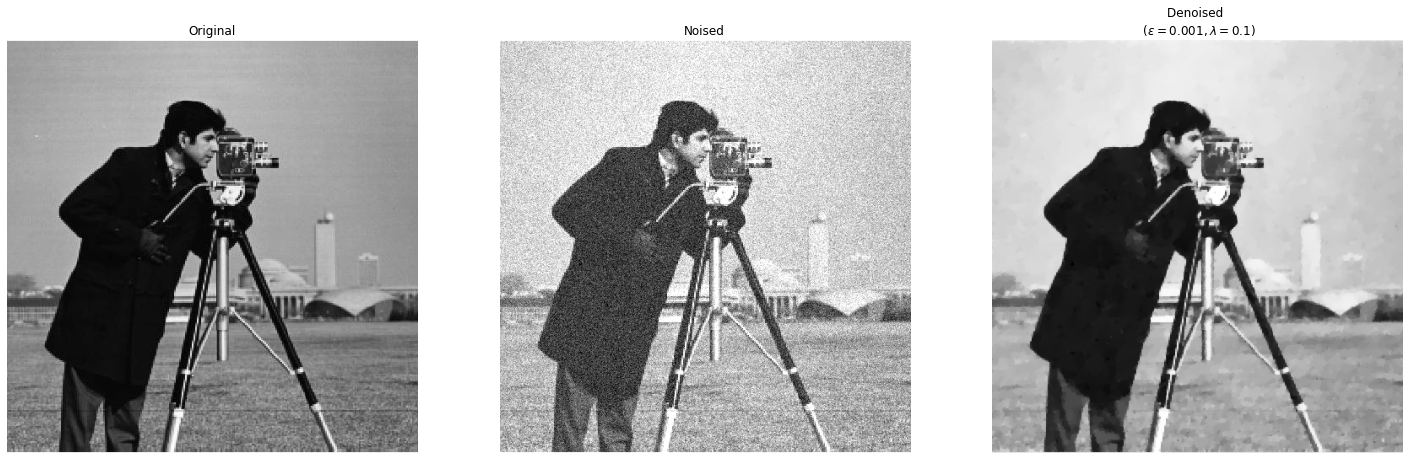

In [22]:
fig ,axs = plt.subplots(1,3,figsize=(25,25))
axs[0].imshow(ej2,cmap="gray")
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(ej2_noise,cmap="gray")
axs[1].set_title('Noised')
axs[1].axis('off')
axs[2].imshow(X2c,cmap="gray")
axs[2].set_title('Denoised \n ($\epsilon=0.001,\lambda=0.1$)')
axs[2].axis('off')
plt.savefig('Imagenes/ejemplo2-3.jpg',bbox_inches='tight')
plt.show()

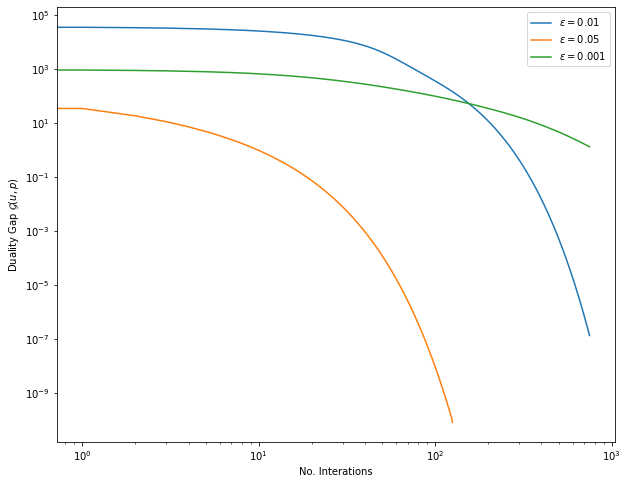

In [23]:
plt.figure(figsize=(10, 8))
plt.plot(I2a,G2a,label='$\epsilon=0.01$')
plt.plot(I2b,G2b,label='$\epsilon=0.05$')
plt.plot(I2c,G2c,label='$\epsilon=0.001$')
plt.legend()
plt.xscale('log')
plt.xlabel('No. Interations')
plt.yscale('log')
plt.ylabel('Duality Gap $\mathcal{G}(u,p)$')
plt.savefig('Imagenes/graf2.jpg',bbox_inches='tight')